# Description
### This notebook is designed to show uses of formal_tests.py, a script designed to present some robust information regarding the barotropic model. For example, understanding the required number of ensemble members to sample the forcing, and finding the zonally symmetric climatological variance caused by the forcing.

In [1]:
#import packages
#%matplotlib notebook

import sys
sys.path.append('../src')  # Add the 'src' directory to the Python path
from model.solver import Solver #bm3_barotropic_model packages
from model.sphere import Sphere
from model.forcing import Forcing

from utils import constants, plotting, config
import ensemble_methods as em

import time
import numpy as np
import random
import xarray as xr

import cartopy as crt             # Map projection stuff
import cartopy.crs as ccrs

import matplotlib as mpl          # Plotting routines
import matplotlib.pyplot as plt    

from tqdm import tqdm

import json


/home/bertossa/miniconda3/envs/jupyter/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1.1) Do the basic properties of the model align with previous studies?

In [3]:
T= 40*constants.day2sec#total integration time

st = Sphere()
params = config.held_1985(st)

print(params)

sln = Solver(st, T= T, **params).integrate_dynamics(verbose=True)

plotting.plot_energy(sln)


{'rs': 0.0, 'tau': 0.0, 'nu': 10000.0, 'diffusion_order': 1, 'robert_filter': 0.01, 'dt': 1800, 'forcing_type': 'none', 'temp_linear': True, 'vort_linear': False}


  0%|                                                  | 0/1920 [00:00<?, ?it/s]


ValueError: forcing type not recognized

In [5]:
json.dumps(params)

'{"rs": 0.0, "tau": 0.0, "nu": 10000.0, "diffusion_order": 1, "robert_filter": 0.01, "dt": 1800, "forcing_type": "none", "temp_linear": true, "vort_linear": false}'

## 2.1 Check how many members are needed to sample forcing well
Here we run just the red noise forcing out to 10 years to represent the climatological spread. Then, an ensemble of size e, of the forcing equation is generated for a single timestep. The variance of the ensemble represents the ability for an ensemble of size e to produce the climatological spread at any given time. This is repeated for a couple hundred runs to capture the spread of the estimated variance. Results for a single coordinate are plotted below; i've picked the a location that aligns with our stirring latitude. Small ensembles initially underestimate the climatological variance, but quickly asymptote to the climatology value. As the ensemble size increases, the spread in the estimated variance decreases as well. 200 seems like a pretty good number?

  0%|                                                 | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_13764/290532743.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  climatology[nm]=fmem.evolve_rededdy()
100%|███████████████████████████████████| 50000/50000 [00:40<00:00, 1242.40it/s]


<IPython.core.display.Javascript object>


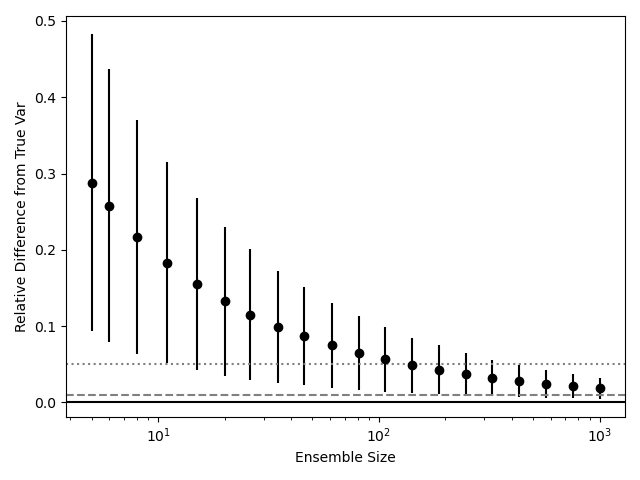

In [115]:
# generate an very large ensemble of forcings to create a pseudo-climatology
st= Sphere(base_state='solid')

clim_mem = 50000
climatology = np.empty((clim_mem, st.nspecindx))

for nm in tqdm(range(clim_mem)):
    fmem = Forcing(sphere=st)
    climatology[nm]=fmem.evolve_rededdy()

# Calculate the 'true' variance for each wavenumber in the ensemble
true_variance = climatology.std(axis=0)

# Define a range of ensemble sizes to test
ensemble_sizes = np.logspace( np.log10(5), np.log10(1000), 20).astype(int)
nruns = 100 #number of runs for each ensemble size

# Function to subsample and calculate variance
def subsample_variance(data, subsample_size, num_repeats):
    # generate an array of variances for each subsample
    return np.array([np.std(data[np.random.choice(data.shape[0], subsample_size, replace=True)], axis=0) for _ in range(num_repeats)])

ens_runs = np.empty((len(ensemble_sizes), nruns, st.nspecindx))
for ii, size in enumerate(ensemble_sizes):
    ens_runs[ii,:] = subsample_variance(climatology, size, num_repeats=nruns)

#For each ensemble size and each run,
#calculate mean absolute relative error of ensemble (sample) variance from true variance.
#Since there is a forcing on each wavenumber, use the sum of the MARE to characterize.
ens_mean_err    = np.mean(np.mean(np.abs(ens_runs - true_variance)/true_variance,axis=1), axis=1)
#Use the variance of the sample variance to plot error bars.
ens_mean_err_std= np.mean( np.std(np.abs(ens_runs - true_variance)/true_variance,axis=1), axis=1)

#We'll say that the ensemble becomes a good estimator of the 'true' variance when its mean dips below 5% error.
plt.figure()
plt.errorbar(ensemble_sizes, ens_mean_err, yerr=ens_mean_err_std, fmt='o', color = 'k')
    
plt.axhline(y=0., color='k', linestyle='-', label='True Variance')
plt.axhline(y=0.01, color='gray', linestyle='--')
plt.axhline(y=0.05, color='gray', linestyle=':')


plt.xlabel('Ensemble Size')
plt.ylabel(f'Relative Difference from True Var')
#plt.legend()
plt.xscale('log')
plt.tight_layout()
plt.show()

## 2.2 Derive Climatological Spread
Run a single model for a long time (10 yrs) to what ensemble spread should be at very long lead times. Note that even for a very long simulation, there is some variance as a function of longitude in the climatology, so we use a random sampling approach to help reduce particular initialization

In [2]:
climatology= xr.open_dataset('/doppler/data8/bertossa/bm3/climatology_nonlinear_seaice.nc')

In [3]:
# Function to subsample and calculate variance
def subsample_variance(data, subsample_size, num_repeats):
    # generate an array of variances for each subsample
    return np.array([np.std(data[np.random.choice(data.shape[0], subsample_size, replace=True)], axis=0) for _ in range(num_repeats)])

nruns=1000
sampsize = 100
variances = subsample_variance(climatology.theta.values, sampsize, num_repeats=nruns)

# Extract the coordinates and dimensions from the original DataArray
original_coords = climatology.theta.isel(time=0).coords
original_dims = climatology.theta.isel(time=0).dims

# Create a new DataArray with an additional dimension for runs
new_dims = ('run',) + original_dims
new_coords = {'run': np.arange(nruns)}
for dim in original_dims:
    new_coords[dim] = original_coords[dim]

# Create the new DataArray
rsample_climate = xr.DataArray(variances, dims=new_dims, coords=new_coords)

In [4]:
climatology.close()

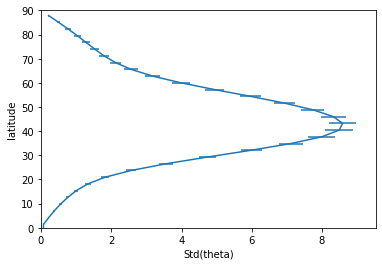

In [5]:
plt.figure()
plt.errorbar(y=rsample_climate.y.values,
             x= rsample_climate.mean('x').mean('run'),
             xerr=2*rsample_climate.mean('x').std('run'), label = 'climatological spread')
plt.ylabel('latitude')
plt.xlabel('Std(theta)')
plt.xlim(0)
plt.ylim(0,90)
plt.show()

## 2.3 Check to see how long it takes for ensemble to approach climatology
Using our derived climatology from 2.2, and an ensemble of size n, lets run a 6-week long simulation and see how our ensemble behaves.

In [13]:
ensemble = xr.open_dataset('/doppler/data8/bertossa/bm3/LE_nonlinear_seaice2.nc').theta
ensemble_var = ensemble.std('ens_mem')

Processing:   1%|                        | 1636/314325 [00:20<11:18, 461.11it/s]

In [14]:
climate_ub = rsample_climate.mean(['x','run'])+2*rsample_climate.mean('x').std('run')
climate_lb = rsample_climate.mean(['x','run'])-2*rsample_climate.mean('x').std('run')

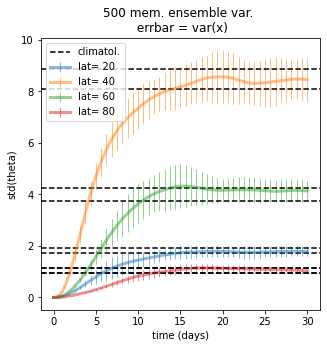

In [15]:
tidx=ensemble.time.size-1

s2d = 1/60./60./24.
fig = plt.figure(figsize=(5,5))
ys= [20,40,60,80]


for y in ys:
    plt.errorbar(ensemble.time, ensemble_var.sel(y=y, method='nearest').mean('x'),
                 errorevery=5, lw=3, elinewidth=1, label = f'lat= {y}',
                 yerr= 2*ensemble_var.sel(y=y, method='nearest').std('x'), alpha=0.5)


    plt.axhline(climate_ub.sel(y=y, method='nearest'), 0,1, color = 'k', linestyle = '--')
    plt.axhline(climate_lb.sel(y=y, method='nearest'), 0,1, color = 'k', linestyle = '--')
    
plt.axhline(climate_ub.sel(y=y, method='nearest'), 0,1, color = 'k', linestyle = '--', label = 'climatol.')
plt.axhline(climate_lb.sel(y=y, method='nearest'), 0,1, color = 'k', linestyle = '--')
plt.title('500 mem. ensemble var. \n errbar = var(x)')
plt.xlabel('time (days)')
plt.ylabel("std(theta)")
plt.legend()
plt.show()


In [9]:
#a mask timeseries to see when all latitudes reach climate_var
at_climo = np.empty(( len(ensemble.time), len(ensemble.y) ))

ensemble_spread_ub = ensemble_var.mean('x')+2*ensemble_var.std('x')
ensemble_spread_lb = ensemble_var.mean('x')-2*ensemble_var.std('x')

for t in tqdm(range(len(ensemble.time))):
    at_climo[t,:] = (ensemble_spread_ub.isel(time=t) > climate_lb)

100%|███████████████████████████████████████| 241/241 [00:00<00:00, 1454.49it/s]


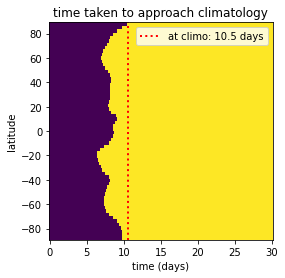

In [10]:
plt.figure(figsize=(4,4))
plt.pcolormesh(ensemble.time,ensemble.y,at_climo.T)
reached_time = ensemble.time[np.where(at_climo.sum(axis=-1) == at_climo.shape[-1])[0][0]]
plt.axvline(reached_time,
            label = f'at climo: {reached_time.values:.1f} days', linestyle=':', color = 'r', lw=2)
plt.xlabel('time (days)')
plt.ylabel('latitude')
plt.title('time taken to approach climatology')
plt.legend()
plt.show()

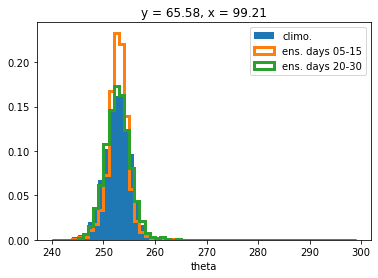

In [33]:
loc = [65, 100]
#st = Sphere()

climatology.theta.sel(y=loc[0],method='nearest').sel(x=loc[1],method='nearest').plot.hist(
    bins=np.arange(240,300,1), density=True, label= 'climo.')


ensemble.sel(y=loc[0],method='nearest').sel(x=loc[1],method='nearest').sel(time=slice(5,15)).plot.hist(
    bins=np.arange(240,300,1),lw=3, density=True, histtype='step', label = 'ens. days 05-15')

ensemble.sel(y=loc[0],method='nearest').sel(x=loc[1],method='nearest').sel(time=slice(20,30)).plot.hist(
    bins=np.arange(240,300,1),lw=3, density=True, histtype='step', label = 'ens. days 20-30')


plt.legend()


plt.show()

In [35]:
#ensemble_ss = ensemble.sel(y=slice(75,45)).sel(time=slice(2,30)).sel(ens_mem=slice(0,200))
ensemble_ss = ensemble.sel(y=slice(80,10)).sel(time=slice(2,30)).sel(ens_mem=slice(0,200))

bm, Ms, ms = em.find_bimodality(ensemble_ss, return_roots=True)

Processing:  34%|███████▌              | 243991/714375 [08:57<25:03, 312.76it/s]

KeyboardInterrupt: 

In [18]:
print('freq of bimodality: ', len(np.argwhere(bm.values==True))/bm.values.size )

freq of bimodality:  0.00036586335798934223


In [85]:
from importlib import reload
reload(em)

<module 'ensemble_methods' from '/home/bertossa/bm3/bm3_forced_barotropic/tests/../src/ensemble_methods.py'>

ValueError: left cannot be >= right

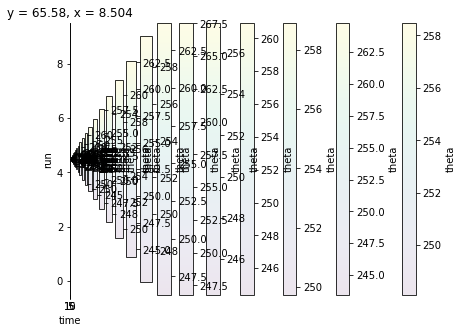

In [27]:
plt.figure(figsize=(7,5))
max_bm_occ = np.unravel_index(bm.sum(dim='time').argmax(), bm.sum(dim='time').shape)
for e in range(200):
    ensemble_ss.isel(y=max_bm_occ[0],x=max_bm_occ[1]).isel(ens_mem=e).plot(x='time', color='grey', alpha=0.1)
for m in range(5):
    Ms.isel(y=max_bm_occ[0],x=max_bm_occ[1]).isel(maxs=m).plot(x='time')
plt.show()

[ 8  4  3 30]


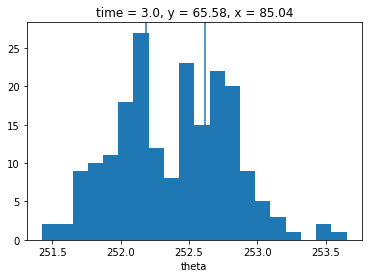

In [58]:

indices = np.argwhere(bm.values==True)
random_index = indices[np.random.choice(indices.shape[0])]
print(random_index)
index_dict = {dim: idx for dim, idx in zip(bm.dims, random_index)}

# bm_pt= bm.isel(y=max_bm_occ[0],x=max_bm_occ[1])
# indices = np.argwhere(bm_pt.values==True)
# random_index = indices[np.random.choice(indices.shape[0])]
# index_dict = {dim: idx for dim, idx in zip(bm_pt.dims, random_index)}
# index_dict['y']=max_bm_occ[0]
# index_dict['x']=max_bm_occ[1]

selected_data = ensemble_ss.isel(index_dict)
selected_data.plot.hist(bins=20)
[plt.axvline(i) for i in Ms.isel(index_dict).values]
plt.show()

In [34]:
bm

<xarray.DataArray 'theta' (run: 10, time: 41, y: 7, x: 127)>
array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
...
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]]])
Coordinates:
  * time     (time) float64 5.0 5.25 5.5 5.75 6.0 ... 14.0 14.25 14.5 14.75 15.0
  * y        (y) float64 68.37 65.58 62.79 60.0 57.21 54.42 51.63
  * x        (x) float64 0.0 2.835 5.669 8.504 11.34 ... 348.7 351.5 354.3 357.2
Dimensions without coordinates: run

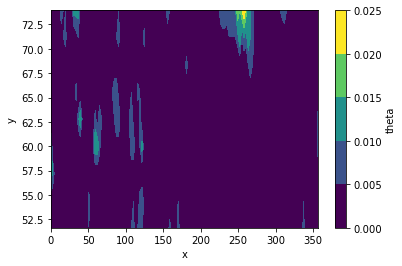

In [56]:
bm.mean(['run','time']).plot.contourf()

# open multiple sims

In [10]:
ensemble = xr.open_mfdataset('/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run[1-9][0-9].nc', concat_dim = 'run', combine='nested').theta
ensemble_ss = ensemble.sel(y=slice(75,50)).sel(time=slice(2,12)).sel(ens_mem=slice(0,200))
ensemble_ss = ensemble_ss[:,:,::2,:,:]
ensemble_ss
#ensemble_ss.load()
#bm, Ms, ms = em.find_bimodality(ensemble_ss, return_roots=True)

#ensemble_var = ensemble.std('ens_mem')

<xarray.DataArray 'theta' (run: 20, ens_mem: 200, time: 41, y: 9, x: 127)>
dask.array<getitem, shape=(20, 200, 41, 9, 127), dtype=float64, chunksize=(1, 200, 41, 9, 127), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.0 2.25 2.5 2.75 3.0 ... 11.0 11.25 11.5 11.75 12.0
  * y        (y) float64 73.95 71.16 68.37 65.58 62.79 60.0 57.21 54.42 51.63
  * x        (x) float64 0.0 2.835 5.669 8.504 11.34 ... 348.7 351.5 354.3 357.2
Dimensions without coordinates: run, ens_mem

In [11]:
ensemble_ss.load()
bm, Ms, ms = em.find_bimodality(ensemble_ss, return_roots=True)
#print('freq of bimodality: ', len(np.argwhere(bm.values==True))/bm.values.size )

Processing: 253451it [09:38, 430.11it/s]                                        
KeyboardInterrupt



In [9]:
import glob
glob.glob('/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run[1-9][0-9].nc')

['/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run10.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run11.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run12.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run13.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run14.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run15.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run16.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run17.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run18.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run19.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run20.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run21.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run22.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run23.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run24.nc',
 '/doppler/data8/bertossa/bm3/LE_nonlinear_seaice_run25.nc',
 '/doppler/data8/bertoss